In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import (
    callbacks, layers,
    backend as K,
    Model, Sequential
)

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (
    f1_score, roc_auc_score,
    accuracy_score, classification_report
)

from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

from nltk.tokenize import word_tokenize

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def vocab_compute(serie):
    return set(sum(map(word_tokenize, serie.to_list()), []))

In [4]:
def build_mlp():
    inp = layers.Input(shape = (vocab_size,))
    x = layers.Dense(
        4096,
        activation = 'relu',
        kernel_initializer = 'glorot_normal',
        kernel_constraint=max_norm(2)
    )(inp)
    x = layers.Dropout(.1)(x)
    
    x = layers.Dense(
        1024, kernel_initializer = 'glorot_normal',
        activation= 'relu'
    )(x)
    x = layers.Dropout(.1)(x)
    
    x = layers.Dense(4, activation = 'softmax')(x)
    
    return Model(inputs = inp, outputs = x)

In [5]:
train = pd.read_pickle("../data/datasets/train_classic.pkl")
val = pd.read_pickle("../data/datasets/val_classic.pkl")
test = pd.read_pickle("../data/datasets/test_classic.pkl")

In [6]:
vocab_size = 6000
input_length = vocab_size + 1
num_labels = train.label.nunique()
batch_size = 512
nb_epoch = 100

In [7]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train.tweet)

In [8]:
x_train = tokenizer.texts_to_matrix(train.tweet, mode='tfidf')
x_val = tokenizer.texts_to_matrix(val.tweet, mode='tfidf')

In [9]:
encoder = LabelBinarizer()
encoder.fit(train.label)
y_train = encoder.transform(train.label)
y_val = encoder.transform(val.label)

# Entraînement
## Réseau à 2 couches simple

In [10]:
with tf.device('/gpu:0'):
    model_1 = build_mlp()

In [11]:
with tf.device('/gpu:0'):
    model_1.compile(
        loss = 'categorical_crossentropy',
        optimizer = tf.keras.optimizers.Adam(1e-5),
        metrics = ['accuracy']
    )
    
    early = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    )

In [12]:
with tf.device('/gpu:0'):
    history = model_1.fit(
        x_train, y_train,
        batch_size = batch_size,
        epochs = nb_epoch,
        verbose = 1,
        validation_data = (x_val, y_val),
        callbacks = [early],
        use_multiprocessing = True
    )

Epoch 1/100
10/10 [==============================] - 1s 89ms/step - loss: 1.2711 - accuracy: 0.4132 - val_loss: 1.1793 - val_accuracy: 0.5094
Epoch 2/100
10/10 [==============================] - 1s 73ms/step - loss: 1.1115 - accuracy: 0.5248 - val_loss: 1.0881 - val_accuracy: 0.5266
Epoch 3/100
10/10 [==============================] - 1s 74ms/step - loss: 1.0388 - accuracy: 0.5367 - val_loss: 1.0456 - val_accuracy: 0.5312
Epoch 4/100
10/10 [==============================] - 1s 75ms/step - loss: 0.9957 - accuracy: 0.5596 - val_loss: 1.0219 - val_accuracy: 0.5500
Epoch 5/100
10/10 [==============================] - 1s 73ms/step - loss: 0.9664 - accuracy: 0.5858 - val_loss: 1.0051 - val_accuracy: 0.5570
Epoch 6/100
10/10 [==============================] - 1s 74ms/step - loss: 0.9408 - accuracy: 0.6073 - val_loss: 0.9911 - val_accuracy: 0.5656
Epoch 7/100
10/10 [==============================] - 1s 74ms/step - loss: 0.9154 - accuracy: 0.6168 - val_loss: 0.9787 - val_accuracy: 0.5688
Epoch 

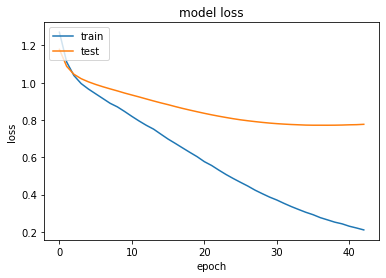

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Réseau à 2 couches, données équilibrées

In [14]:
with tf.device('/gpu:0'):
    model_2 = build_mlp()
    
    model_2.compile(
        loss = 'categorical_crossentropy',
        optimizer = tf.keras.optimizers.Adam(1e-5),
        metrics = ['accuracy']
    )
    
    train_gen, train_steps = balanced_batch_generator(
        x_train, y_train, sampler = RandomOverSampler(),
        batch_size = batch_size, random_state = 42069, 
    )
    
    history = model_2.fit(
        train_gen,
        epochs = nb_epoch,
        validation_data = (x_val, y_val),
        steps_per_epoch = 50,
        callbacks = [early],
        verbose = 1
    )

D:\Programmes\Anaconda3\envs\jobclf\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/100
50/50 [==============================] - 3s 64ms/step - loss: 1.2446 - accuracy: 0.5268 - val_loss: 1.2916 - val_accuracy: 0.4391
Epoch 2/100
50/50 [==============================] - 3s 61ms/step - loss: 0.9659 - accuracy: 0.7784 - val_loss: 1.1564 - val_accuracy: 0.5437
Epoch 3/100
50/50 [==============================] - 3s 61ms/step - loss: 0.7470 - accuracy: 0.8618 - val_loss: 1.0378 - val_accuracy: 0.5859
Epoch 4/100
50/50 [==============================] - 4s 82ms/step - loss: 0.5757 - accuracy: 0.9080 - val_loss: 0.9465 - val_accuracy: 0.6289
Epoch 5/100
50/50 [==============================] - 3s 63ms/step - loss: 0.4520 - accuracy: 0.9275 - val_loss: 0.8817 - val_accuracy: 0.6516
Epoch 6/100
50/50 [==============================] - 3s 65ms/step - loss: 0.3561 - accuracy: 0.9446 - val_loss: 0.8399 - val_accuracy: 0.6594
Epoch 7/100
50/50 [==============================] - 3s 63ms/step - loss: 0.2833 - accuracy: 0.9574 - val_loss: 0.8079 - val_accuracy: 0.6648
Epoch 

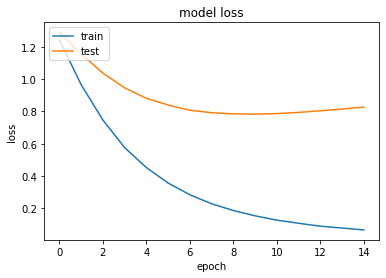

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluation

In [16]:
train = pd.concat([train, val])
val = train.sample(frac=.1)

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train.tweet)
x_train = tokenizer.texts_to_matrix(train.tweet, mode='tfidf')
x_val = tokenizer.texts_to_matrix(val.tweet, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test.tweet, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(train.label)
y_train = encoder.transform(train.label)
y_val = encoder.transform(val.label)
y_test = encoder.transform(test.label)
y_true = np.argmax(y_test, axis = 1)

## Modèle avec les données déséquilibrées

In [17]:
with tf.device('/gpu:0'):
    final_model_1 = build_mlp()
    
    final_model_1.compile(
        loss = 'categorical_crossentropy',
        optimizer = tf.keras.optimizers.Adam(1e-5),
        metrics = ['accuracy']
    )
    
    history = final_model_1.fit(
        x_train, y_train,
        batch_size = batch_size,
        epochs = nb_epoch,
        validation_data = (x_val, y_val),
        callbacks = [early],
        verbose = 0,
        use_multiprocessing = True
    )
    
    pred_1 = final_model_1.predict(x_test)
    y_1 = np.argmax(pred_1, axis = 1)
print(classification_report(y_true, y_1))

print("F1-score: {}\nAUC: {}\nAccuracy: {}".format(
    f1_score(y_true, y_1, average = "macro"),
    roc_auc_score(y_test, pred_1, average = "macro", multi_class = "ovr"),
    accuracy_score(y_true, y_1)
))

              precision    recall  f1-score   support

           0       0.50      0.30      0.38       337
           1       0.61      0.84      0.71      1473
           2       0.52      0.56      0.54       950
           3       0.44      0.01      0.03       523

    accuracy                           0.57      3283
   macro avg       0.52      0.43      0.41      3283
weighted avg       0.54      0.57      0.52      3283

F1-score: 0.4122908401318044
AUC: 0.7003205436512758
Accuracy: 0.5726469692354553


## Modèle avec sur-échantillonnage

In [18]:
with tf.device('/gpu:0'):
    final_model_2 = build_mlp()
    
    final_model_2.compile(
        loss = 'categorical_crossentropy',
        optimizer = tf.keras.optimizers.Adam(1e-5),
        metrics = ['accuracy']
    )
    
    train_gen, train_steps = balanced_batch_generator(
        x_train, y_train, sampler = RandomOverSampler(),
        batch_size = batch_size, random_state = 42069, 
    )
    
    history = final_model_2.fit(
        train_gen,
        epochs = nb_epoch,
        validation_data = (x_val, y_val),
        callbacks = [early],
        verbose = 0,
        steps_per_epoch = 40
    )
    
    pred_2 = final_model_2.predict(x_test)
    y_2 = np.argmax(pred_2, axis = 1)
print(classification_report(y_true, y_2))

print("F1-score: {}\nAUC: {}\nAccuracy: {}".format(
    f1_score(y_true, y_2, average = "macro"),
    roc_auc_score(y_test, pred_2, average = "macro", multi_class = "ovr"),
    accuracy_score(y_true, y_2)
))

D:\Programmes\Anaconda3\envs\jobclf\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

           0       0.46      0.34      0.40       337
           1       0.62      0.81      0.70      1473
           2       0.52      0.58      0.55       950
           3       0.29      0.02      0.03       523

    accuracy                           0.57      3283
   macro avg       0.47      0.44      0.42      3283
weighted avg       0.52      0.57      0.52      3283

F1-score: 0.4185482254378488
AUC: 0.7012805926043163
Accuracy: 0.5708193725251295
